In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from ipywidgets import widgets, interact

In [4]:
import sys

sys.path.append('/home/ewout/enem_atp/')
from util import load_sample, load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep, scalecalparams
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Como funciona TRI
A teoria de resposta ao item é uma metodologia para calcular notas a partir de padrões de respostas a "itens" (questões). Vamos começar com um exemplo, carregando uma amostra de alguns dos milhões de candidatos que fizeram a prova de 2023.

```{admonition} Microdados
Para este projeto baixamos [os microdados do ENEM](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados) disponibilizados pelo INEP. Para ver o nosso *pipeline* de processamento de dados e as funções que usamos abaixo, veja o nosso repositório de código: https://github.com/atp/enem
```


In [6]:
load_sample(2023,5)

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
13488,210058450397,2023,2,F,1,4,1,2,0,3,...,B,A,A,B,A,A,E,A,C,B
19989,210061475266,2023,4,M,1,3,1,1,1,1,...,A,A,A,B,A,A,B,A,A,A
19921,210061291899,2023,3,F,0,1,1,2,0,2,...,B,A,B,B,A,B,E,A,C,B
20494,210058900616,2023,9,M,1,3,1,1,7,1,...,A,A,A,B,A,B,D,A,A,B
1348,210059180151,2023,2,F,1,1,1,2,0,2,...,B,A,A,B,A,B,E,B,A,B


Vemos que para cada candidato há informaçoes contextuais (autoreportado, na hora de fazer a inscrição do ENEM) sobre idade, sexo, cor/raça e outros variáveis. Nesta base também constam os padrões de resposta e a nota ENEM determinado pelo INEP. Transformamos estes dados numa outra tabela para facilitar as análises que vamos fazer:

In [7]:
load_acertos(2023,'CN',5)

,40724,60332,126604,117631,43890,85436,26042,83558,64023,87989,...,111665,84422,83378,117887,66330,48492,63155,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210061850009,0,0,1,1,0,0,0,0,1,0,...,1,1,1,0,0,0,0,16,1221,569.0
210060270251,1,0,1,1,0,0,0,1,0,0,...,1,1,1,0,0,0,0,11,1223,521.7
210060574698,1,0,0,0,0,0,0,0,1,0,...,0,0,1,1,0,0,0,11,1224,470.7
210061157645,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,8,1223,442.5
210059803518,1,0,1,1,0,0,0,1,1,1,...,0,1,1,0,0,1,1,19,1222,580.9


## A nota TRI é bem diferente do que o número de acertos
Primeiro, mostramos o que todo mundo que já fez o ENEM sabe: dois candidatos com o mesmo número de acertos podem ter notas ENEM bem diferentes. Não é somente o número de acertos que conta, é também o padrão de respostas que é levado em conta:

<AxesSubplot:xlabel='acertos', ylabel='nota_inep'>

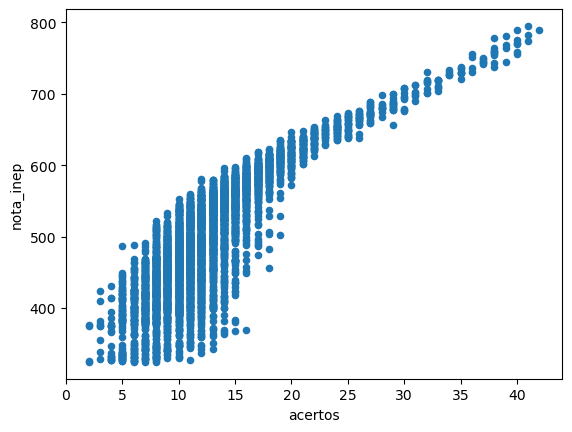

In [51]:
caderno = 1222
df = load_acertos(2023,'CN',5000,prova=caderno)
df.plot(kind='scatter',x='acertos',y='nota_inep')

Vemos que para pessoas com 9 acertos a nota ENEM pode variar de 330 até 530

In [53]:
df.query("acertos == 9")['nota_inep'].describe()

count    452.000000
mean     442.192035
std       40.591383
min      330.100000
25%      414.575000
50%      446.650000
75%      472.625000
max      533.200000
Name: nota_inep, dtype: float64

O que explica esta diferença é o padrão de respostas dos candidatos. De uma forma geral, quem acerta de forma mais consistente ganha uma nota maior. É melhor acertar dois itens fáceis do que acertar um item difícil, por exemplo. O INEP fornece os parâmetros dos itens:

In [57]:
params = params_inep(caderno)
params[:5]

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
12018,1.82986,1.82071,0.19864,1
26042,3.98650,1.63479,0.19026,1
40724,1.87231,-0.45616,0.19791,1
43890,3.63689,1.43988,0.18360,1
47231,5.93670,2.33396,0.11437,1


Com algumas manobras, podemos mostrar a diferença entre as padrões de resposta de dois candidatos com o mesmo número de acertos. Observe que a nota alta é obtida para quem acerto as questões mais fáceis. O padrão com acertos em itens difíceis mas erros em itens fáceis é pouco provável e o algoritmo TRI associa uma nota baixa. 

In [101]:
itens_a = pd.qcut(params['a_inep'],3,labels=['Baixa','Média','Alta'])
itens_b = pd.qcut(params['b_inep'],3,labels=['Baixa','Média','Alta'])
itens = pd.concat([itens_a,itens_b],axis=1)
itens.columns = ['discriminação','dificuldade']
itens[:5]

def compare_padr(nacertos=9):
    padrmin = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmin()]
    padrmax = df.loc[df.query("acertos == @nacertos")['nota_inep'].idxmax()]
    notamin,notamax = padrmin['nota_inep'], padrmax['nota_inep']
    padrmin = padrmin[:-3]; padrmax = padrmax[:-3]
    padrmin.index = padrmin.index.astype(int);padrmax.index = padrmax.index.astype(int)
    result = params.join(itens).join(padrmin).join(padrmax)
    result.columns = ['a','b','c','u','discriminação','dificuldade','nota_baixa','nota_alta']
    result = result.sort_values(['b'],ascending=False).query("nota_baixa == 1 or nota_alta == 1")
    result.columns = ['a','b','c','u','discriminação','dificuldade',f'nota = {notamin}',f'nota = {notamax}']
    return result

iw = widgets.IntText(
    value=9,
    description='Acertos:',
)
interact(compare_padr, nacertos=iw);

interactive(children=(IntText(value=9, description='Acertos:'), Output()), _dom_classes=('widget-interact',))